In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyspiel
import random

from collections import Counter
from collections import defaultdict
from scipy.stats import kruskal

# Define environment and agents 

Load Prisoner's Dilemma game from DeepMind Open Spiel environment. 

- Define Random agent that will select cooperate or defect with equal probability. 
- Define Q Learning agent that will select cooperate or defect by learning Q values of each action. 

In [2]:
global game
game = pyspiel.load_game("matrix_pd")  # load prisoner's dilemma game

class RandomAgent: 
    """
    Random agent that has uniform policy to serve as baseline.
    """

    def __init__(self, player_id, num_actions):
        """
        Attributes:
            player_id (int): agent ID (0,1 )
            num_actions (int): potential actions
        """
        self.player_id = player_id
        self.num_actions = num_actions

    def select_action(self, state):
        """
        Random action selection
        """
        return random.randint(0, self.num_actions - 1)

    def update(self, state, action, reward, next_state):
        """
        Method only for symmetry with other agent
        """
        pass 

    def policy_distribution(self, state): 
        """
        Return policy distribution for the given state.
        """
        return np.ones(self.num_actions) / self.num_actions

    def __str__(self):
        return f"RandomAgent(player_id={self.player_id})"

class QLearningAgent:
    """
    Q-learning agent for Prisoner's Dilemma.
    """

    def __init__(self, player_id, num_actions, alpha=0.05, gamma=0.1, epsilon=0.15):
        """
        Attributes:
            player_id (int): agent ID (0, 1)
            num_actions (int): potential actions
            alpha (float): learning rate
            gamma (float): discount factor
            epsilon (float): exploration rate
        """
        self.player_id = player_id
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(num_actions))

    def select_action(self, state):
        """
        epside-greedy action selection
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            return int(np.argmax(self.Q[state]))

    def update(self, state, action, reward, next_state):
        """
        update Q-value with bellman equation
        """
        best_next_action = int(np.argmax(self.Q[next_state]))
        td_target = reward + self.gamma * self.Q[next_state][best_next_action]
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

        return
    
    def policy_distribution(self, state):
        """
        Return policy distribution for the given state.
        """
        q_values = self.Q[state]
        max_q = np.max(q_values)
        exp_q = np.exp(q_values - max_q)
        return exp_q / np.sum(exp_q)

    def __str__(self):
        return f"QLearningAgent(player_id={self.player_id})"
    

class SARSAAgent:
    """
    SARSA agent for Prisoner's Dilemma.
    """

    def __init__(self, player_id, num_actions, alpha=0.05, gamma=0.1, epsilon=0.15):
        """
        Attributes:
            player_id (int): ID of the agent (0 or 1)
            num_actions (int): Number of possible actions
            alpha (float): Learning rate
            gamma (float): Discount factor
            epsilon (float): Exploration rate
        """
        self.player_id = player_id
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(num_actions))
        self.last_state = None
        self.last_action = None

    def select_action(self, state):
        """
        epsilon-greedy action selection 
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            return int(np.argmax(self.Q[state]))

    def update(self, state, action, reward, next_state):
        """
        update Q-values with SARSA formula
        """
        next_action = self.select_action(next_state)
        td_target = reward + self.gamma * self.Q[next_state][next_action]
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

        self.last_state = next_state
        self.last_action = next_action
        return

    def policy_distribution(self, state):
        """
        softmax distribution over Q-values for entropy computation
        """
        q_values = self.Q[state]
        max_q = np.max(q_values)
        exp_q = np.exp(q_values - max_q)
        return exp_q / np.sum(exp_q)

    def __str__(self):
        return f"SARSAAgent(player_id={self.player_id})"


# Define simulation and helper methods 

- Simulation will use predefined number of episodes, include a random agent if desired, or have both players act as random agents. 
- Define entropy of a policy to help with evaluating learning trajectories. 

In [3]:
def entropy(policy_distribution):
    """
    Calculate entropy of policy distribution 
    """
    return -np.sum(policy_distribution * np.log(policy_distribution + 1e-10))  


def simulate(num_episodes=1000, use_random_baseline=False, use_all_random=False, use_sarsa=False):
    """
    Runs an iterated Prisoner's Dilemma simulation.

    Parameters:
        num_episodes (int): simulated episode count
        use_random_baseline (bool): Declare true if random agent desired
        use_all_random (bool): Declare true if want both agents as random actors 

    Returns:
        rewards_over_time (list): Average reward per episode
        trained_agents (list): List of trained agent instances
    """
    num_players = 2  # define number of players
    num_actions = game.num_distinct_actions()  # store number of unique actions

    if use_all_random:  # check if parameter is true
        agents = [RandomAgent(0, num_actions), RandomAgent(1, num_actions)]  # instantiate random agents when True
    elif use_random_baseline:  # check if parameter is true 
        agents = [QLearningAgent(0, num_actions), RandomAgent(1, num_actions)]  # instantiate random agent when True 
    elif use_sarsa:  # check if parameter is true
        agents = [SARSAAgent(0, num_actions), SARSAAgent(1, num_actions)]  # instantiate SARSA agents when True
    else:  # otherwise false 
        agents = [QLearningAgent(0, num_actions), QLearningAgent(1, num_actions)]  # instantiate Q-learning agents when False

    rewards = []  # initialize empty list to store rewards
    cooperations = []  # initialize empty list to store cooperation rates
    prior_actions = [0, 0]  # initialize empty list to store prior actions
    joint_action_counts = []  # intialize empty list to store joint action counts
    entropies = []  # initialize empty list to store outcome entropies
    action_trajectories = []  # initialize empty list to store action trajectories

    for episode in range(num_episodes):  # iterate across episodes
        state = tuple(prior_actions)  # initialize state as tuple of previous actions 

        actions = [agent.select_action(state) for agent in agents]  # select actions for each agent
        state = game.new_initial_state()  # reset game state
        state.apply_actions(actions)  # pass selected actions to current game state
        
        reward = state.rewards()  # store rewards from game state
        next_state = tuple(actions)  # store next state as tuple of actions taken

        for index, agent in enumerate(agents):  # iterate across agents
            agent.update(state, actions[index], reward[index], next_state)  # update Q values for relevant agent(s) 

        rewards.append(reward)  # store reward from both agents
        prior_actions = actions  # update prior actions for next episode

        cooperation = actions.count(0)  # store number of cooperation outcomes per episode
        cooperations.append(cooperation/num_players)  # store cooperation rate per episode

        joint_action_counts.append(tuple(actions))  # store joint action counts per episode
        action_trajectories.append(tuple(actions))  # store action trajectories per episode

        episode_entropy = [entropy(agent.policy_distribution(state)) for agent in agents]  # calculate entropy for each agent
        entropies.append(np.mean(episode_entropy))  # store average entropy per episode
    
    return rewards, cooperations, agents, joint_action_counts, entropies, action_trajectories  


# Plotting methods 

Define methods to plot statistical measures of agents after running simulation

In [4]:
def describe(name, data):
    return print(f"{name} - Mean: {np.mean(data):.3f}, Std: {np.std(data):.3f}, Max: {np.max(data):.3f}, Min: {np.min(data):.3f}")

def plot_results(rewards, title):
    fig, axis = plt.subplots(figsize=(20, 12))
    axis.plot(np.arange(len(rewards)), rewards, color='#500000')
    axis.set_xlabel('Episode')
    axis.set_ylabel('Reward per Episode')
    axis.set_yticks([1, 3, 5])
    axis.set_title(title)
    plt.show()
    return 

def plot_cooperation(coop_rates, title):
    fig, axis = plt.subplots(figsize=(20, 12))  
    axis.plot(np.arange(len(coop_rates)), coop_rates, color='#500000')
    axis.set_xlabel("Episode")
    axis.set_ylabel("Cooperation Rate")
    axis.set_title(title)
    plt.show()
    return

def plot_joint_action_distribution(joint_actions, title): 
    fig, axis = plt.subplots(figsize=(20, 12))
    labels = ['C-C', 'C-D', 'D-C', 'D-D']  # action labels for each agent 
    keys = [(0, 0), (0, 1), (1, 0), (1, 1)]  # action encodings for each agent 
    counter = Counter(joint_actions)  # Count the joint actions across episodes
    values = [counter.get(k, 0) for k in keys]  # action counts for each agent
    axis.bar(labels, values, color='#500000')  # plot bar graph of action counts
    axis.set_xlabel("Joint Action")
    axis.set_ylabel("Count")
    axis.set_title(title)
    plt.show()


def plot_entropy(entropies, title):
    fig, axis = plt.subplots(figsize=(20, 12))
    axis.plot(np.arange(len(entropies)), entropies, color='#500000')
    axis.set_xlabel("Episode")
    axis.set_ylabel("Average Policy Entropy")
    axis.set_title(title)
    plt.show()
    return

def plot_trajectory(trajectory, title):
    label_map = {(0, 0): "C-C", (0, 1): "C-D", (1, 0): "D-C", (1, 1): "D-D"}  # map labels to action encodings
    y_labels = [label_map[a] for a in trajectory]

    fig, axis = plt.subplots(figsize=(20, 6))
    axis.plot(y_labels, color='#500000')
    axis.set_xlabel("Episode")
    axis.set_ylabel("Joint Action")
    axis.set_title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Run simulation and statistical comparison between Agents

In [7]:
# run simulation for random agents
rewards1, coop_rates1, trained_agents1, joint_action_counts1, entropies1, action_trajectories1 = simulate(
    num_episodes=1000, use_random_baseline=False, use_all_random=True
)
# run simulation for Q-learning agents
rewards2, coop_rates2, trained_agents2, joint_action_counts2, entropies2, action_trajectories2 = simulate(
    num_episodes=1000, use_random_baseline=False, use_all_random=False
)
# run simulation for SARSA agents
rewards3, coop_rates3, trained_agents3, joint_action_counts3, entropies3, action_trajectories3 = simulate(
    num_episodes=1000, use_random_baseline=False, use_all_random=False, use_sarsa=True
)


# Lists of length = num_episodes
avg_rewards1 = np.mean(rewards1, axis=0)
avg_rewards2 = np.mean(rewards2, axis=0)
avg_rewards3 = np.mean(rewards3, axis=0)



describe("Random Agent Avg Reward", avg_rewards1)
describe("Q-Learning Avg Reward", avg_rewards2)
describe("SARSA Avg Reward", avg_rewards3)

# Cooperation comparison
stat, p = kruskal(coop_rates1, coop_rates2)
print(f"Kruskal-Wallis test on Q Learning vs Random cooperation: H={stat:.3f}, p={p:.4f}")
stat, p = kruskal(coop_rates1, coop_rates3)
print(f"Kruskal-Wallis test on SARSA vs Random cooperation: H={stat:.3f}, p={p:.4f}")
stat, p = kruskal(coop_rates2, coop_rates3)
print(f"Kruskal-Wallis test on SARSA vs Q Learning cooperation: H={stat:.3f}, p={p:.4f}")

Random Agent Avg Reward - Mean: 4.124, Std: 0.025, Max: 4.149, Min: 4.099
Q-Learning Avg Reward - Mean: 4.972, Std: 0.030, Max: 5.002, Min: 4.942
SARSA Avg Reward - Mean: 4.956, Std: 0.035, Max: 4.991, Min: 4.921
Kruskal-Wallis test on Q Learning vs Random cooperation: H=733.301, p=0.0000
Kruskal-Wallis test on SARSA vs Random cooperation: H=740.393, p=0.0000
Kruskal-Wallis test on SARSA vs Q Learning cooperation: H=0.156, p=0.6933


# Visualize outcomes 

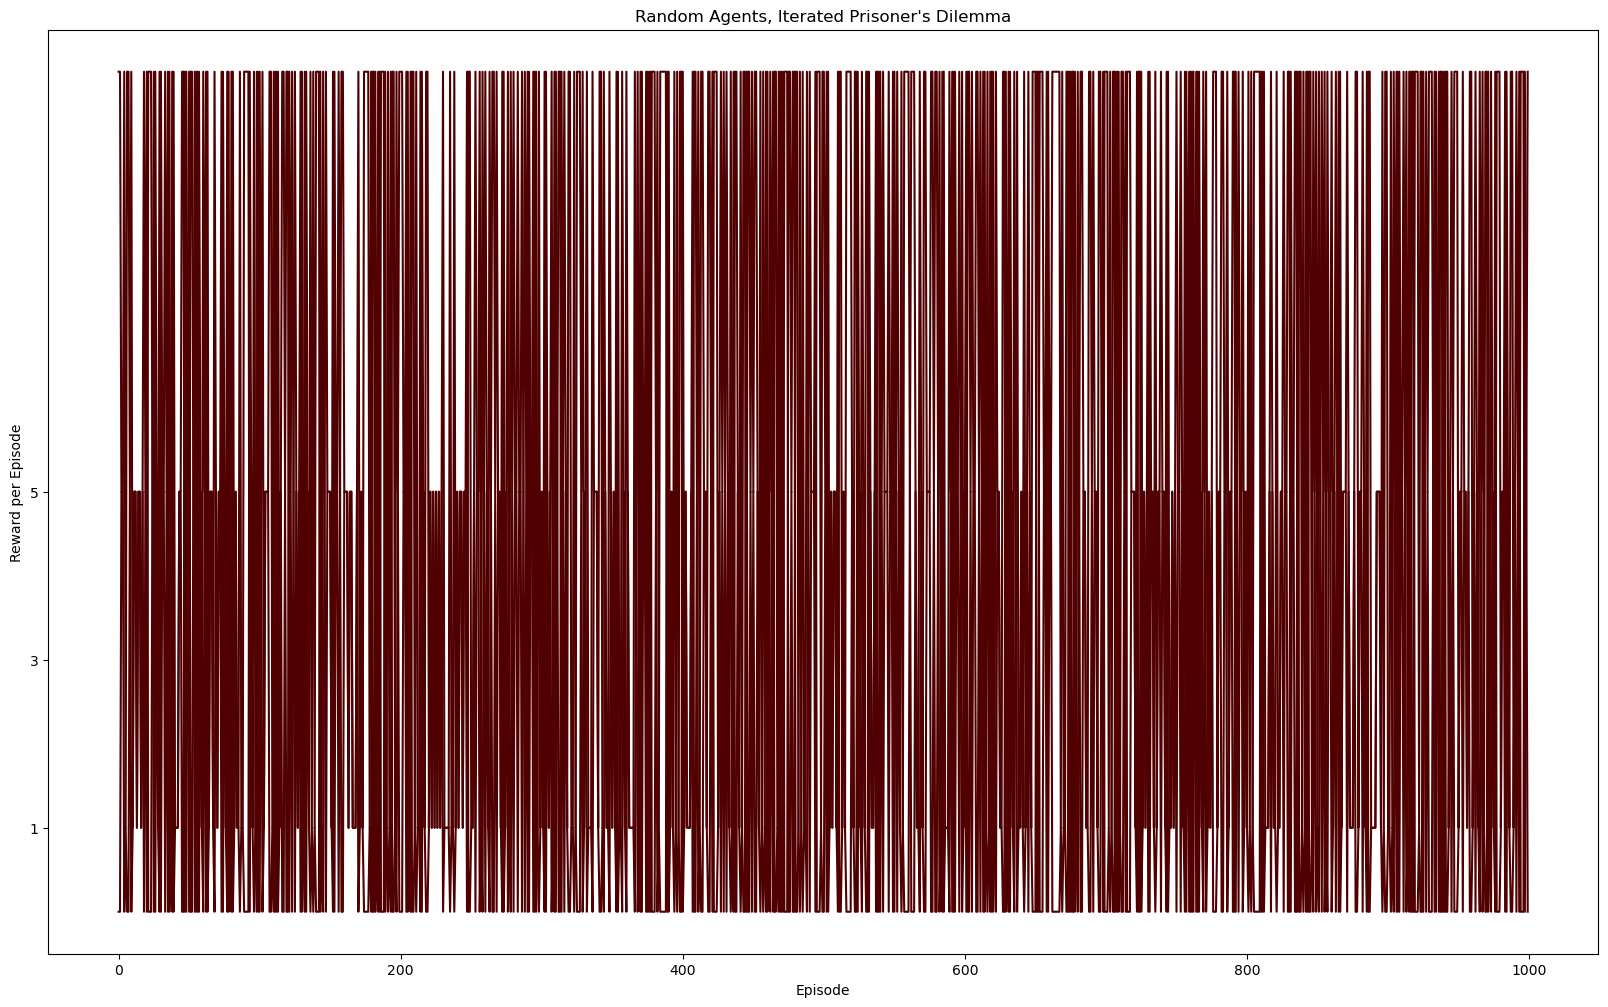

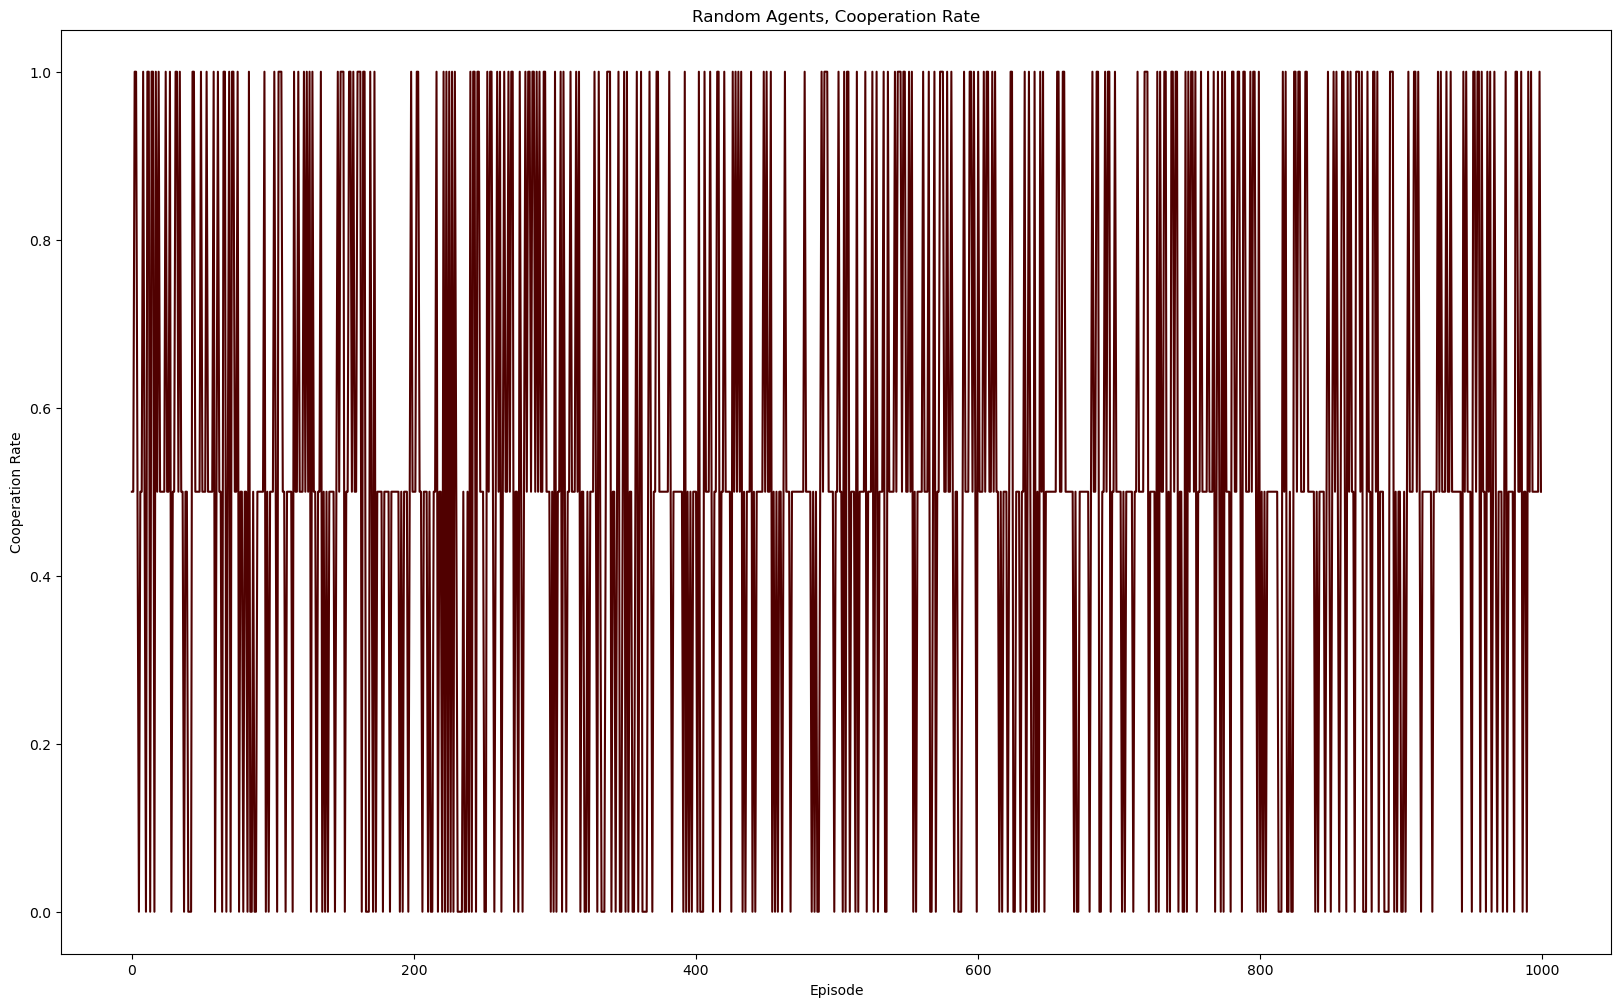

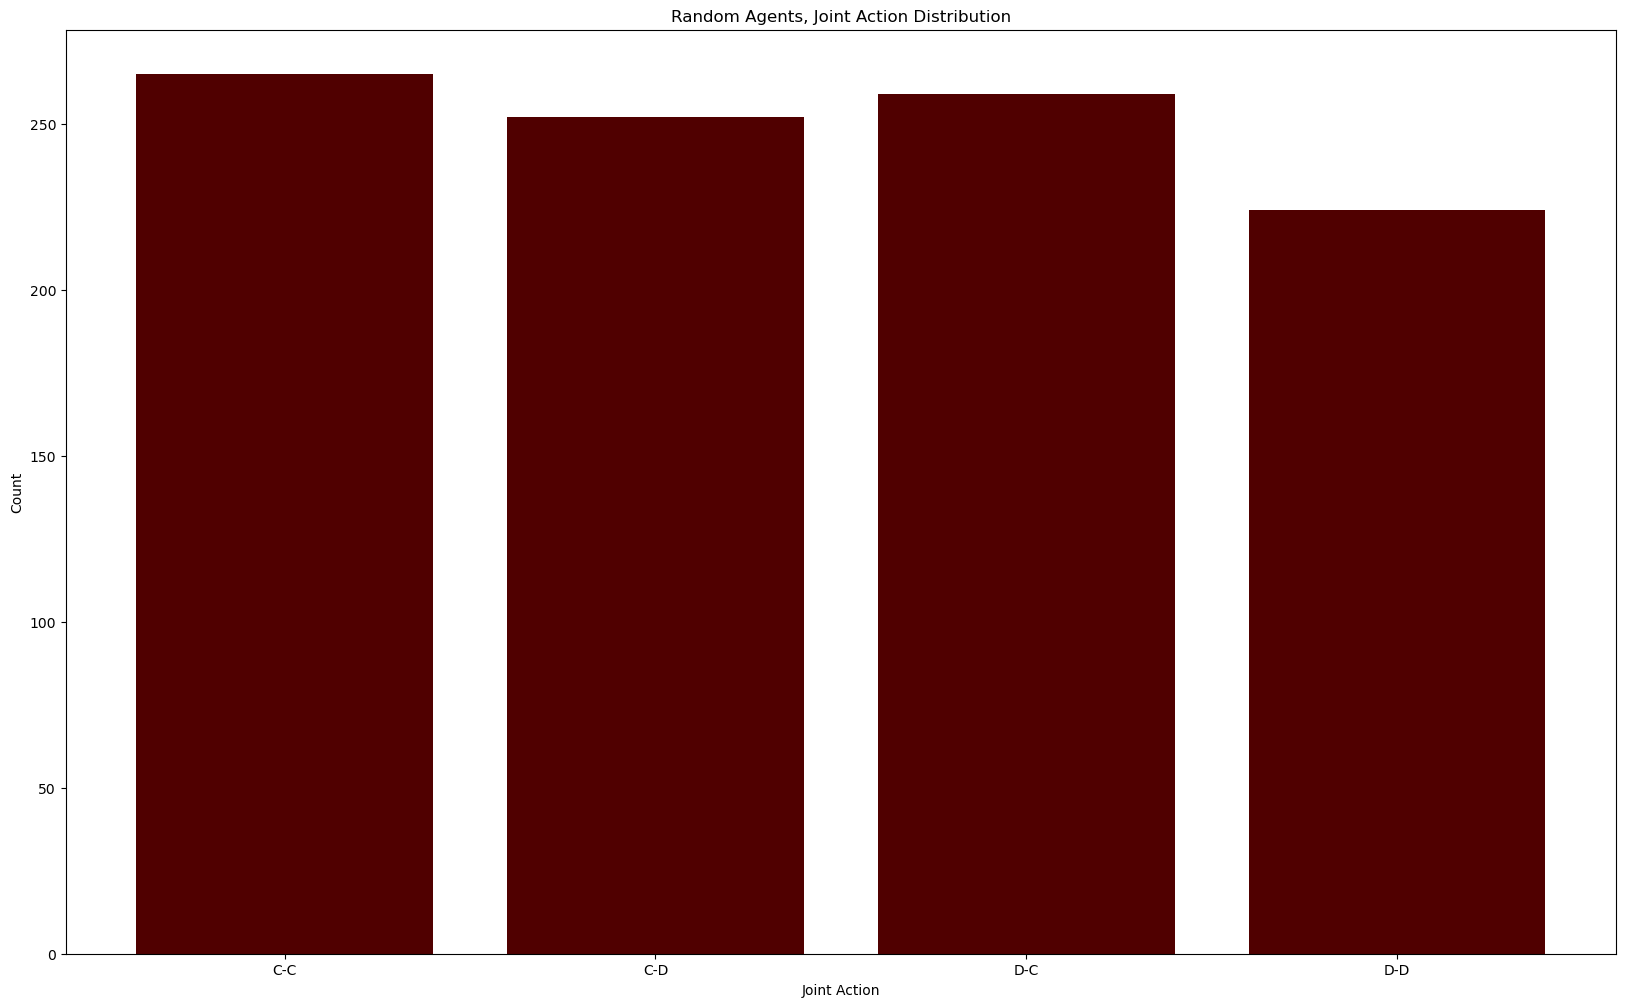

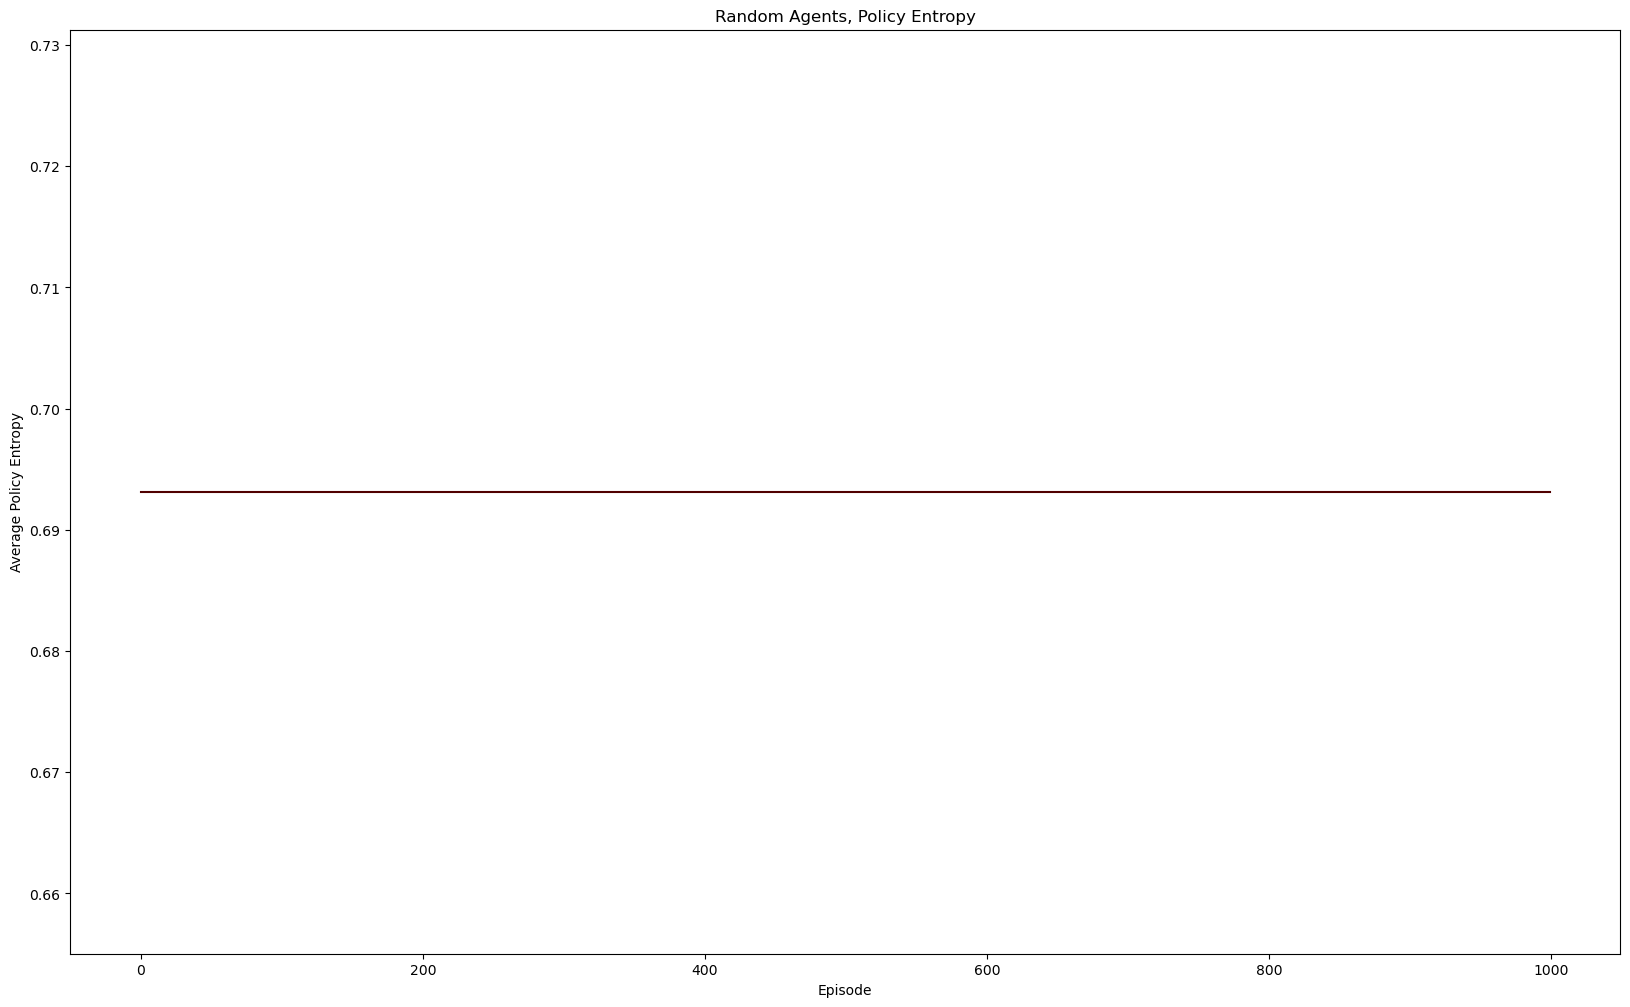

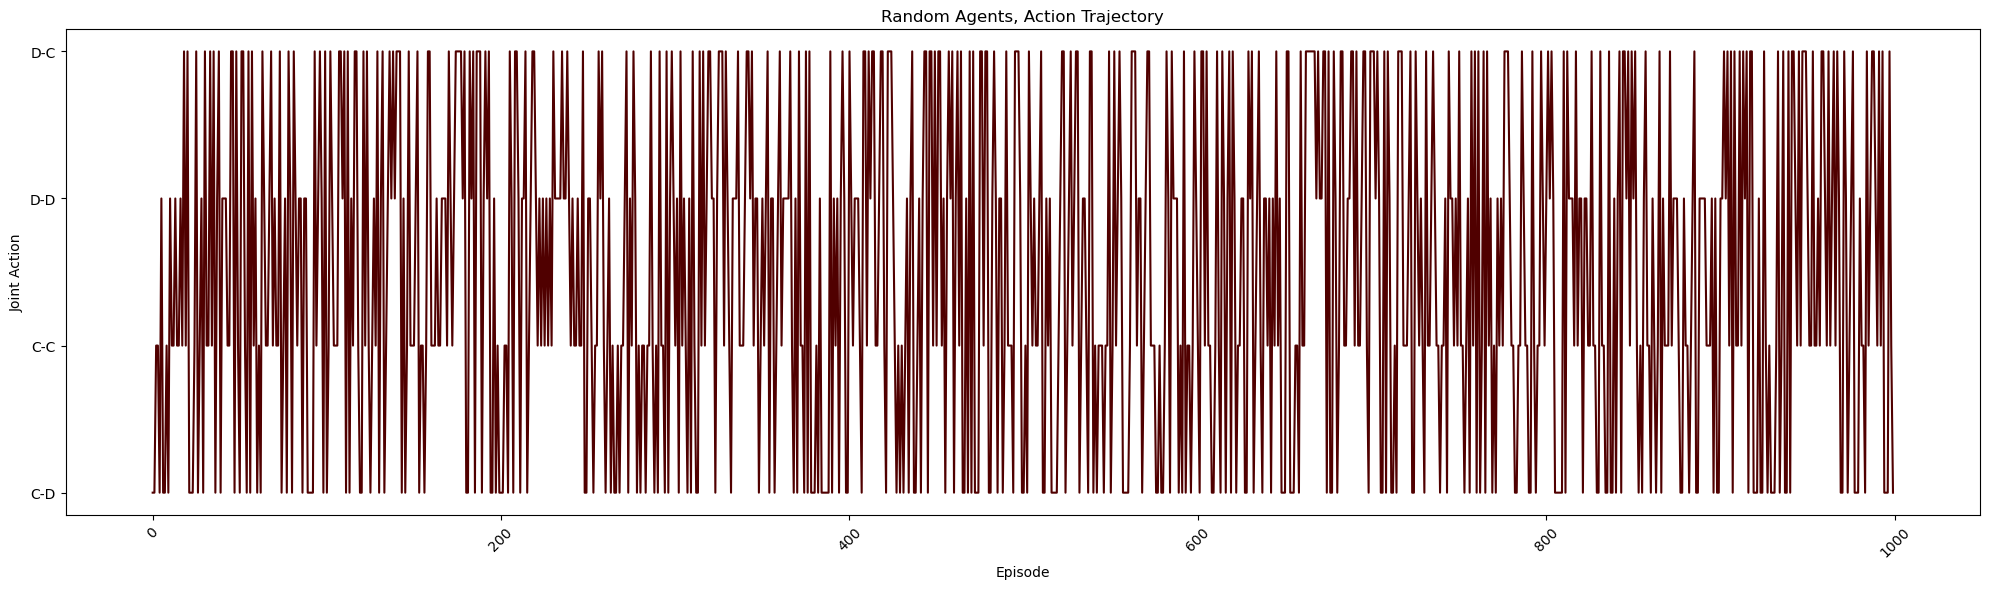

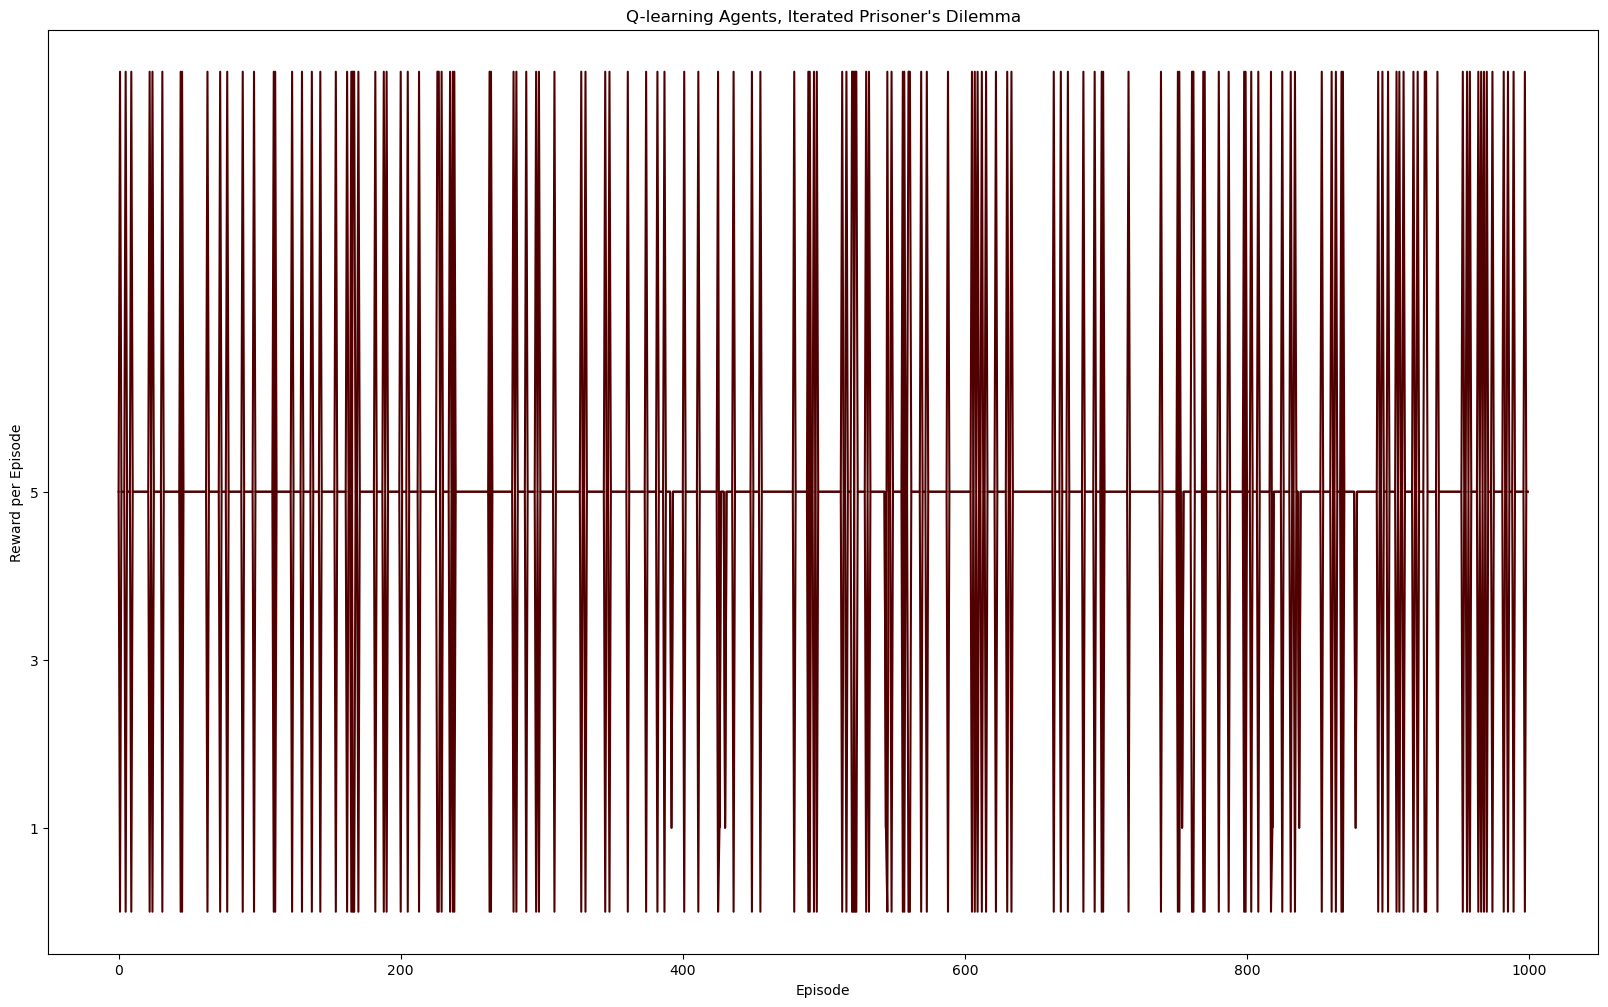

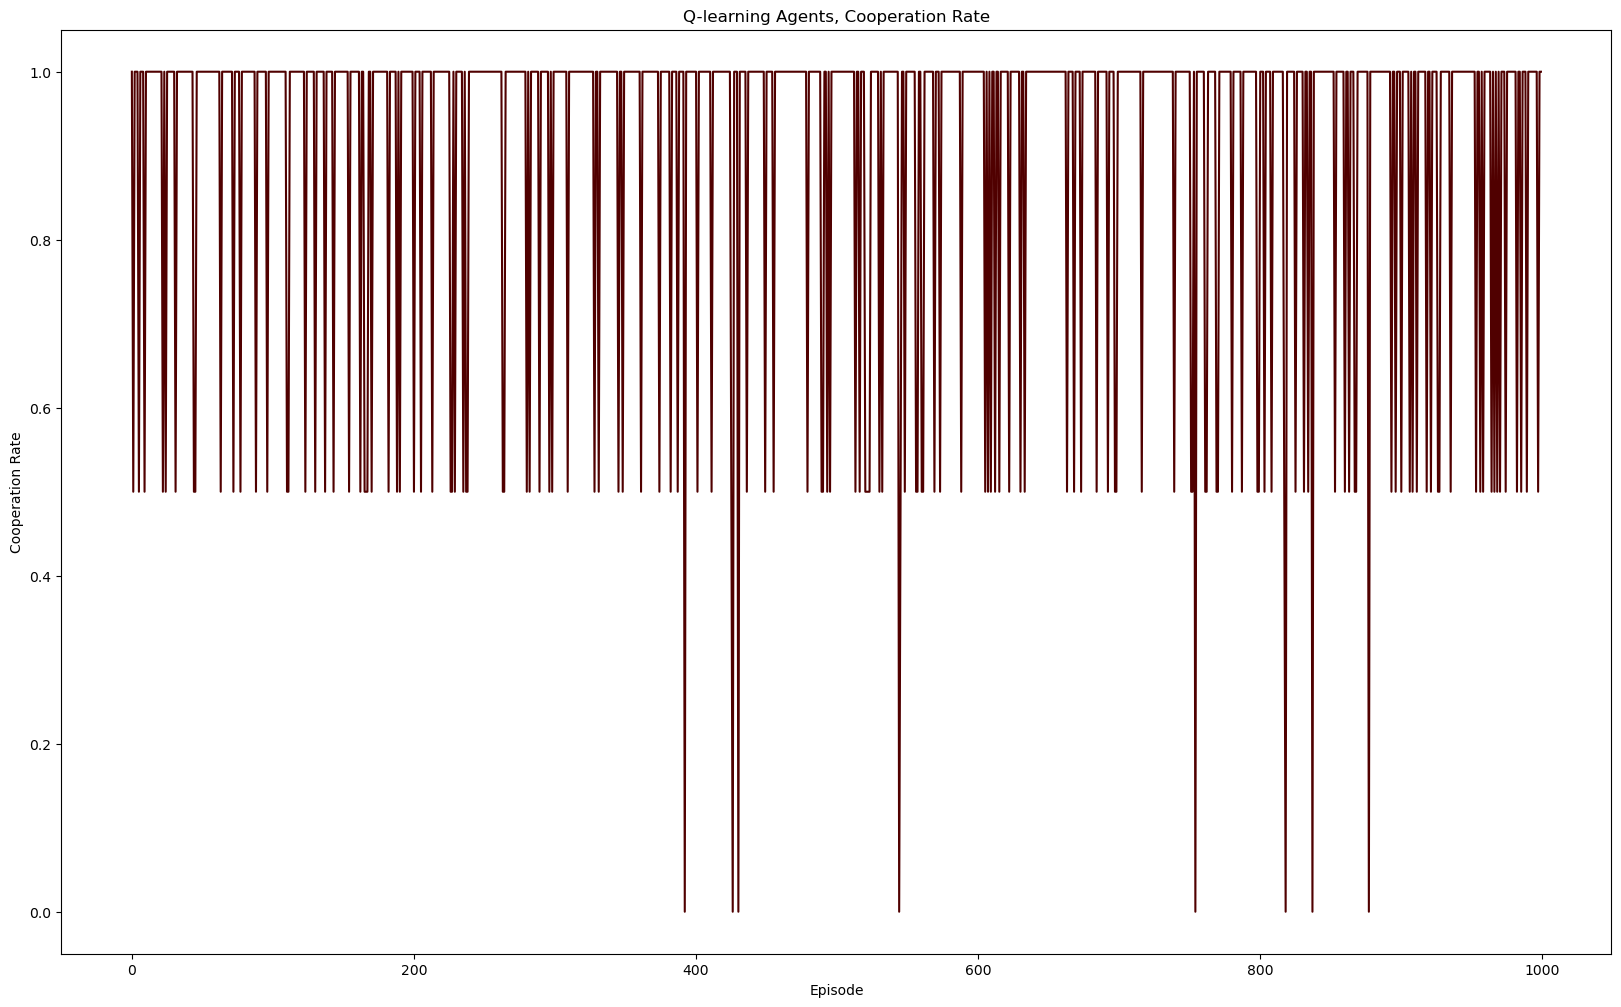

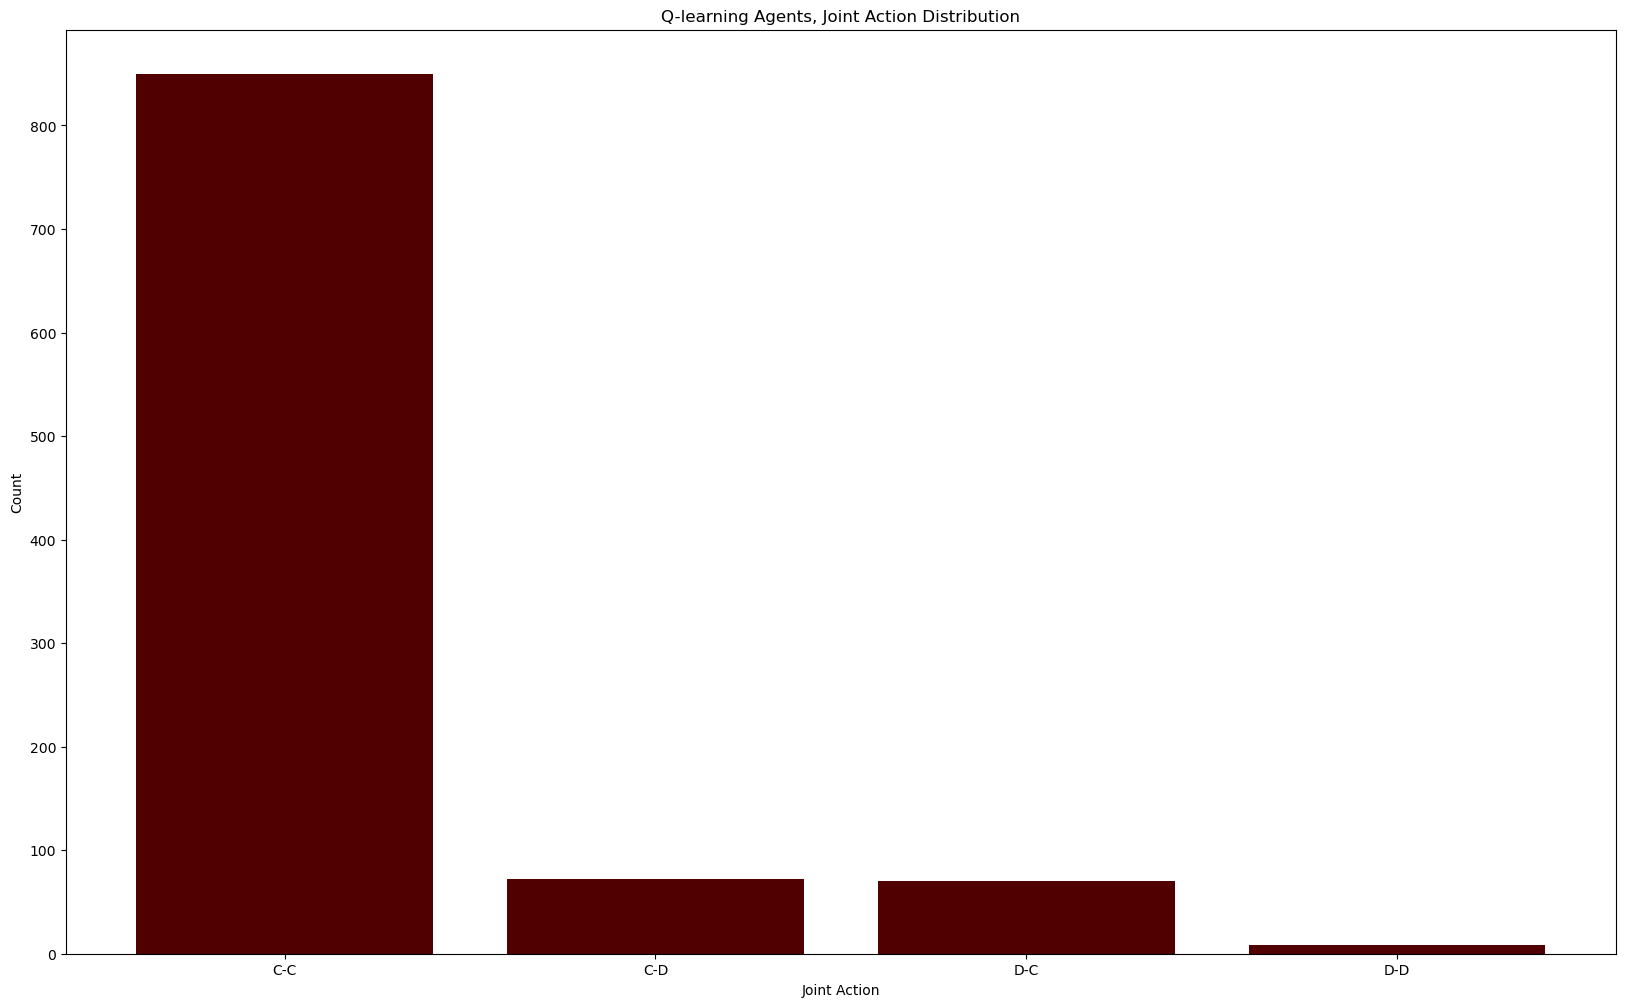

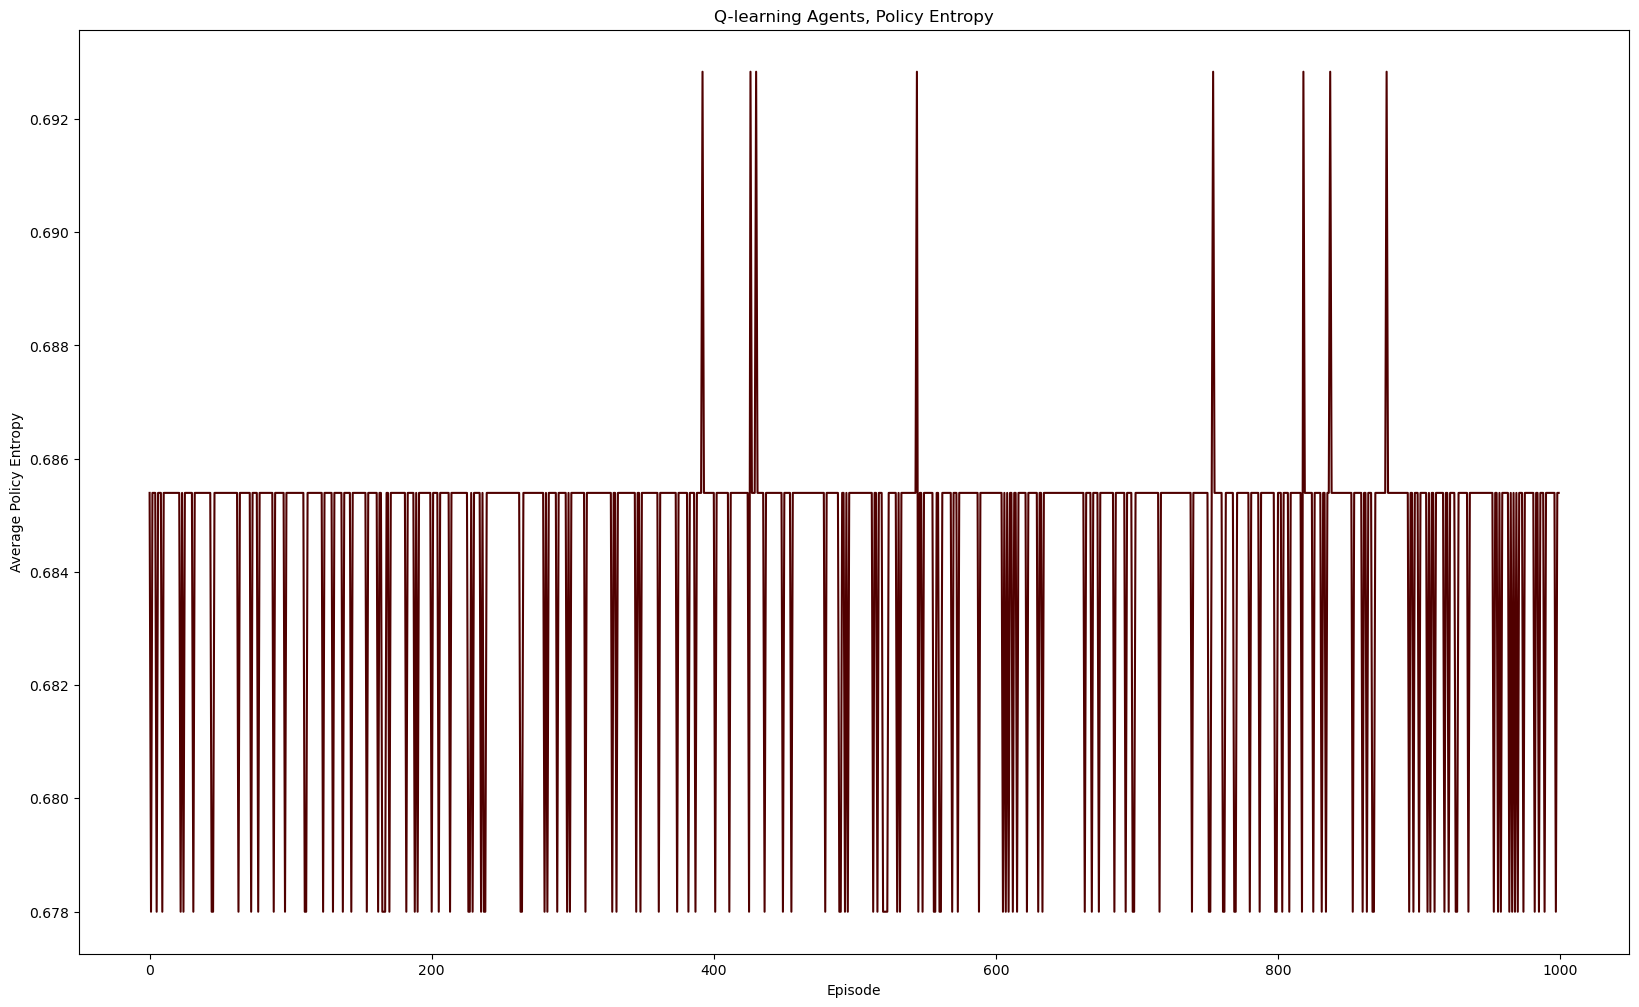

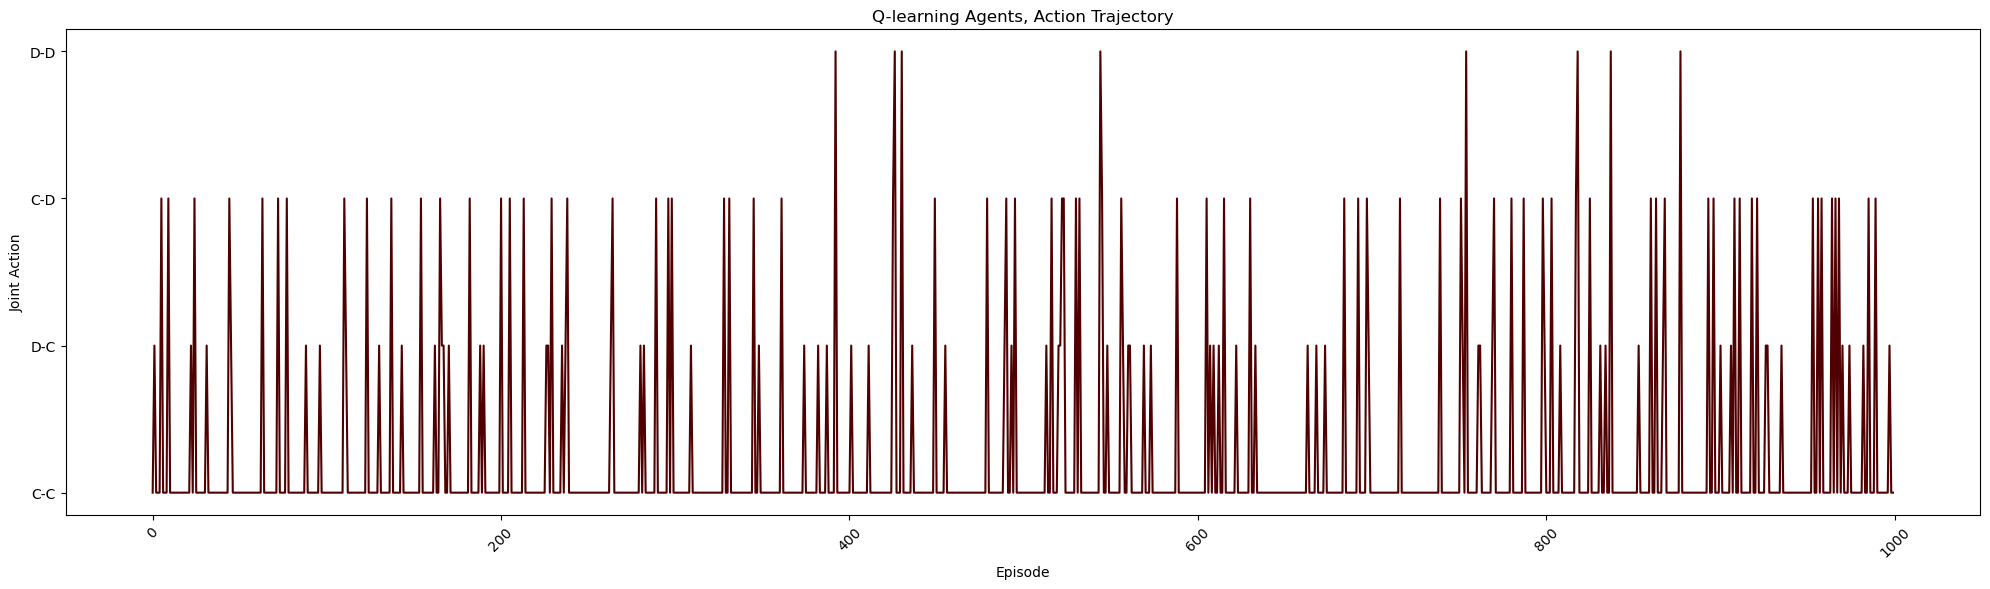

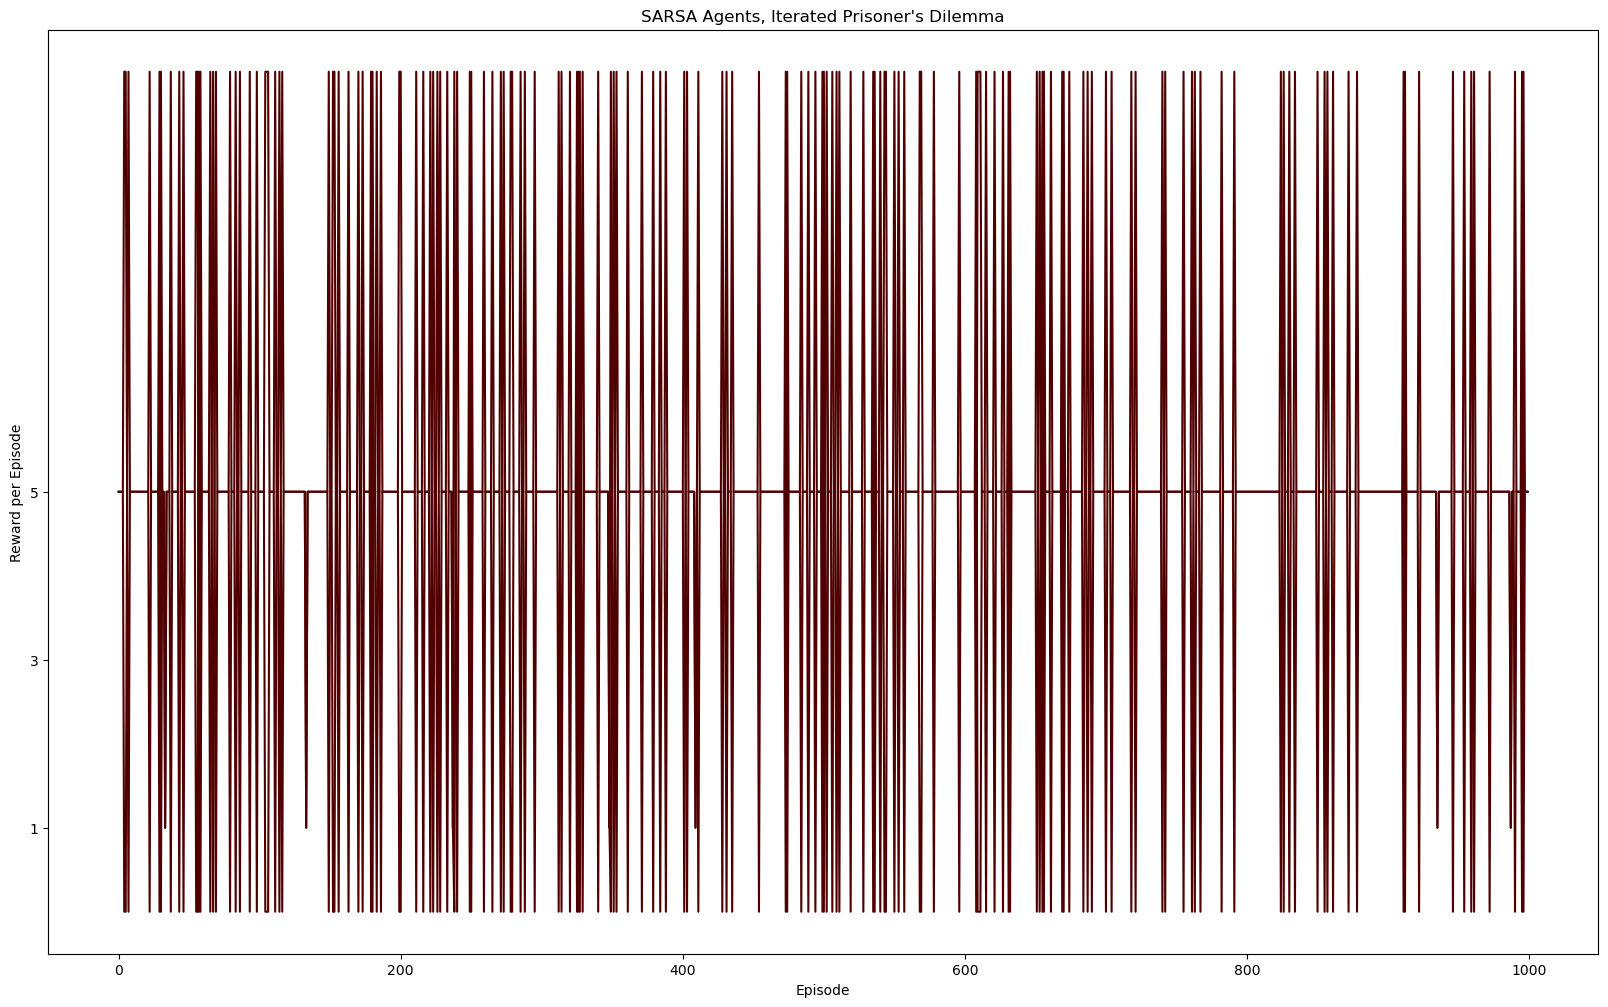

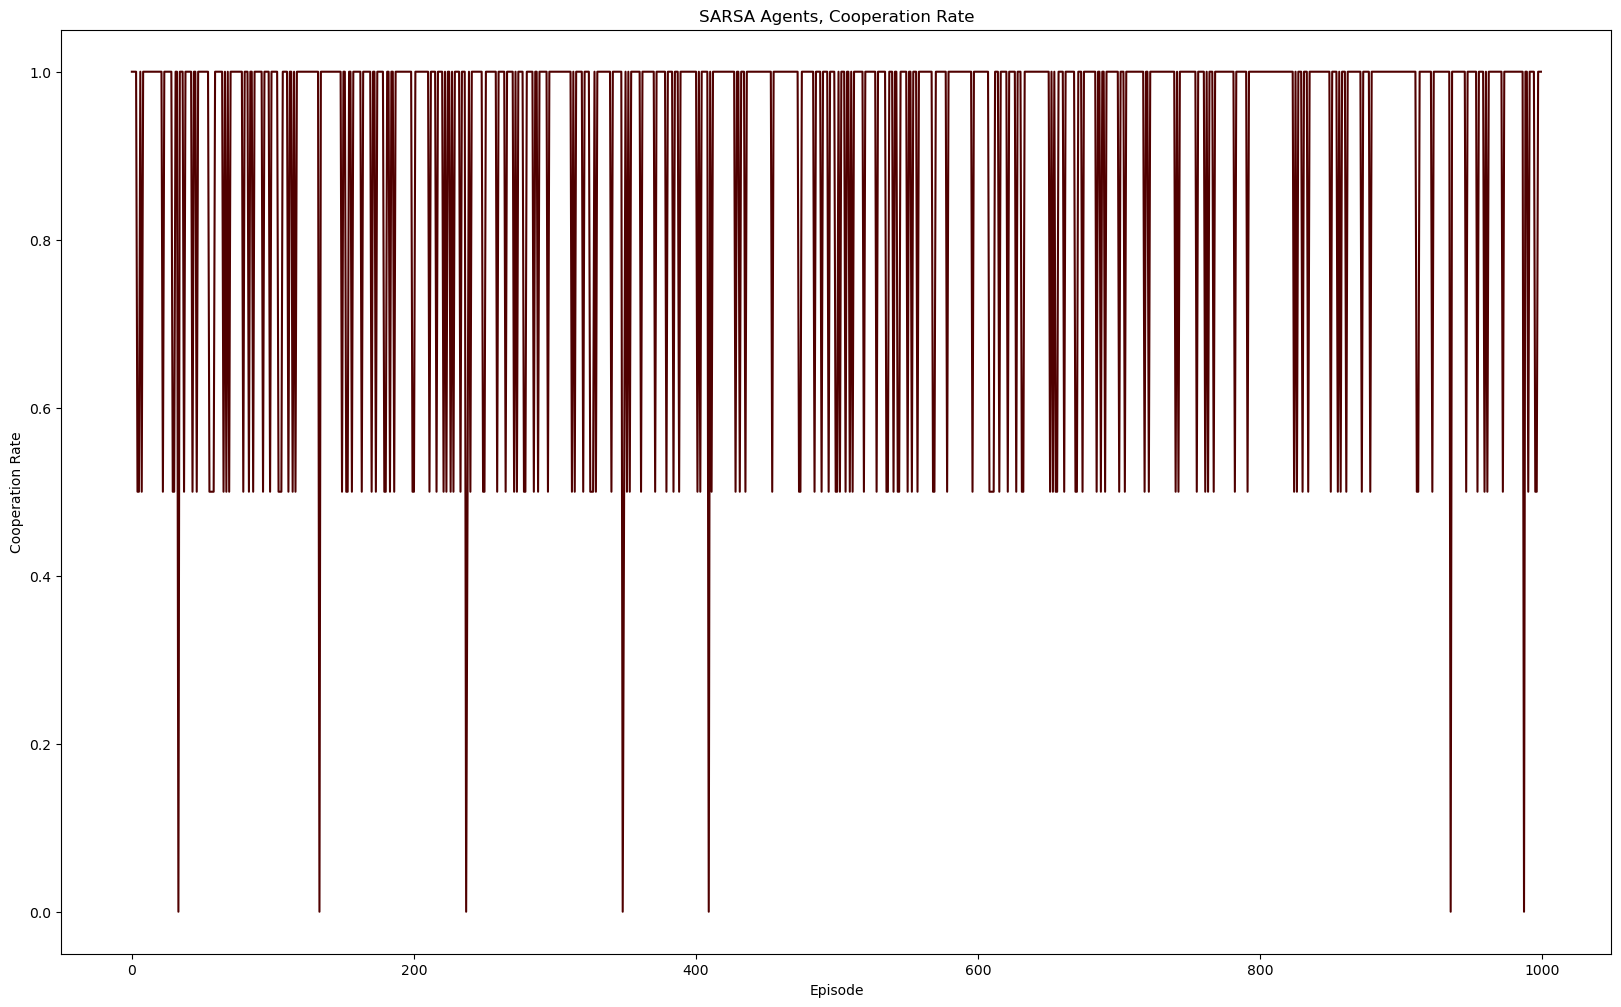

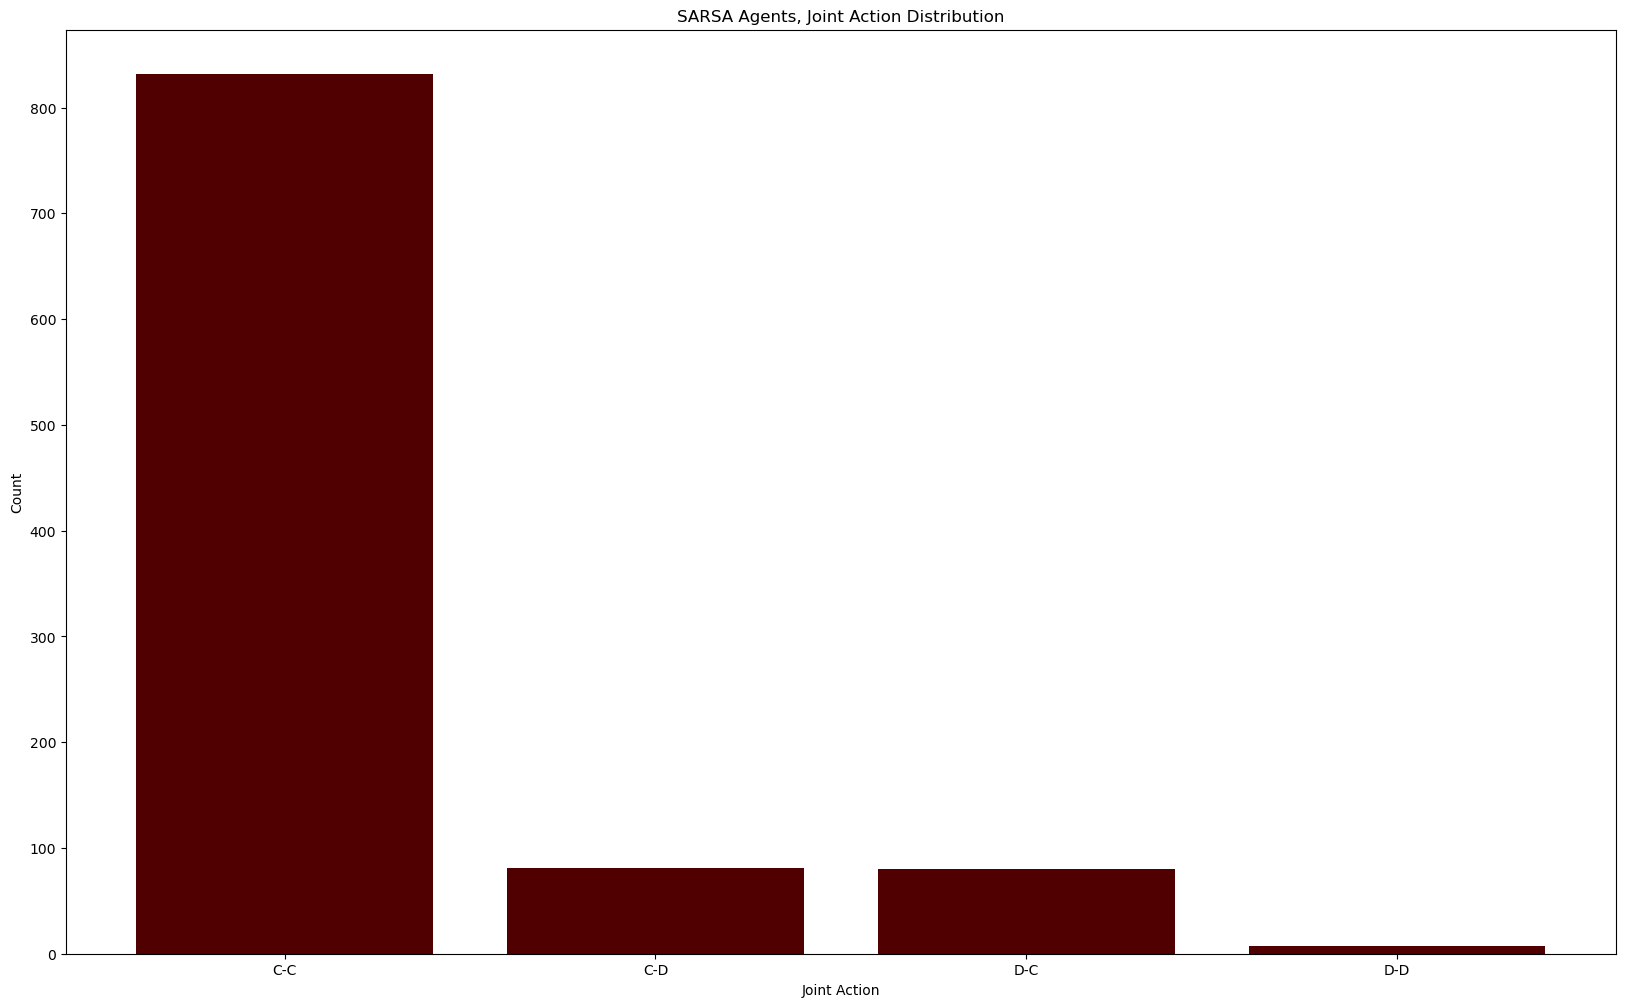

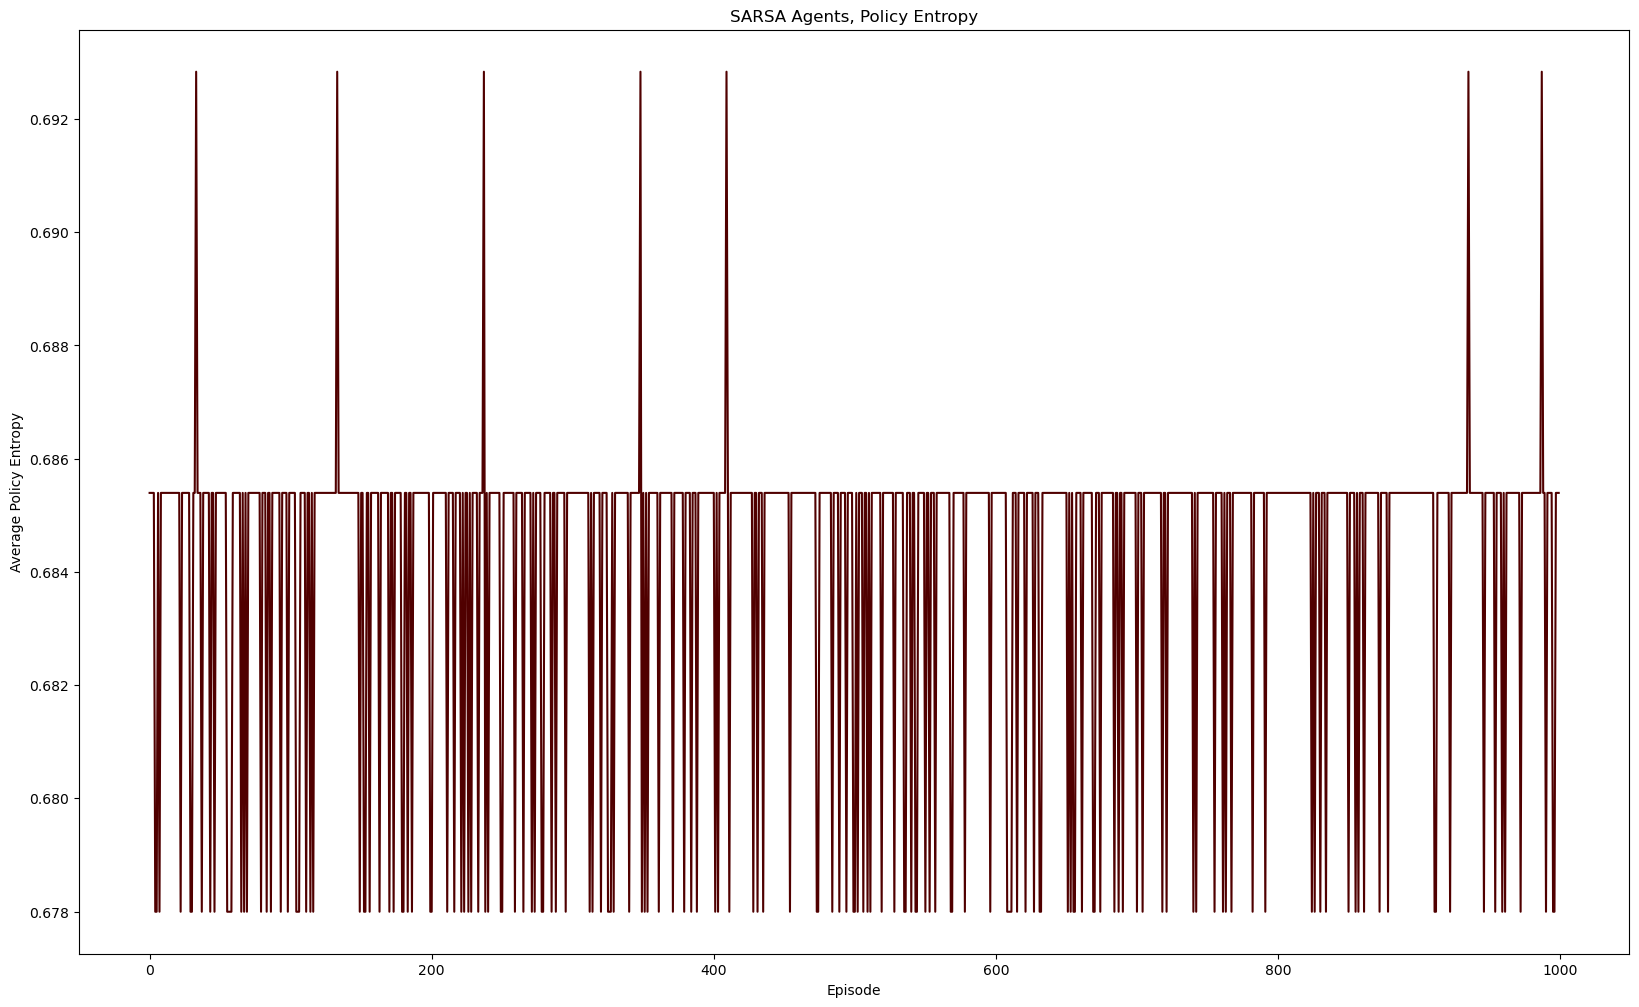

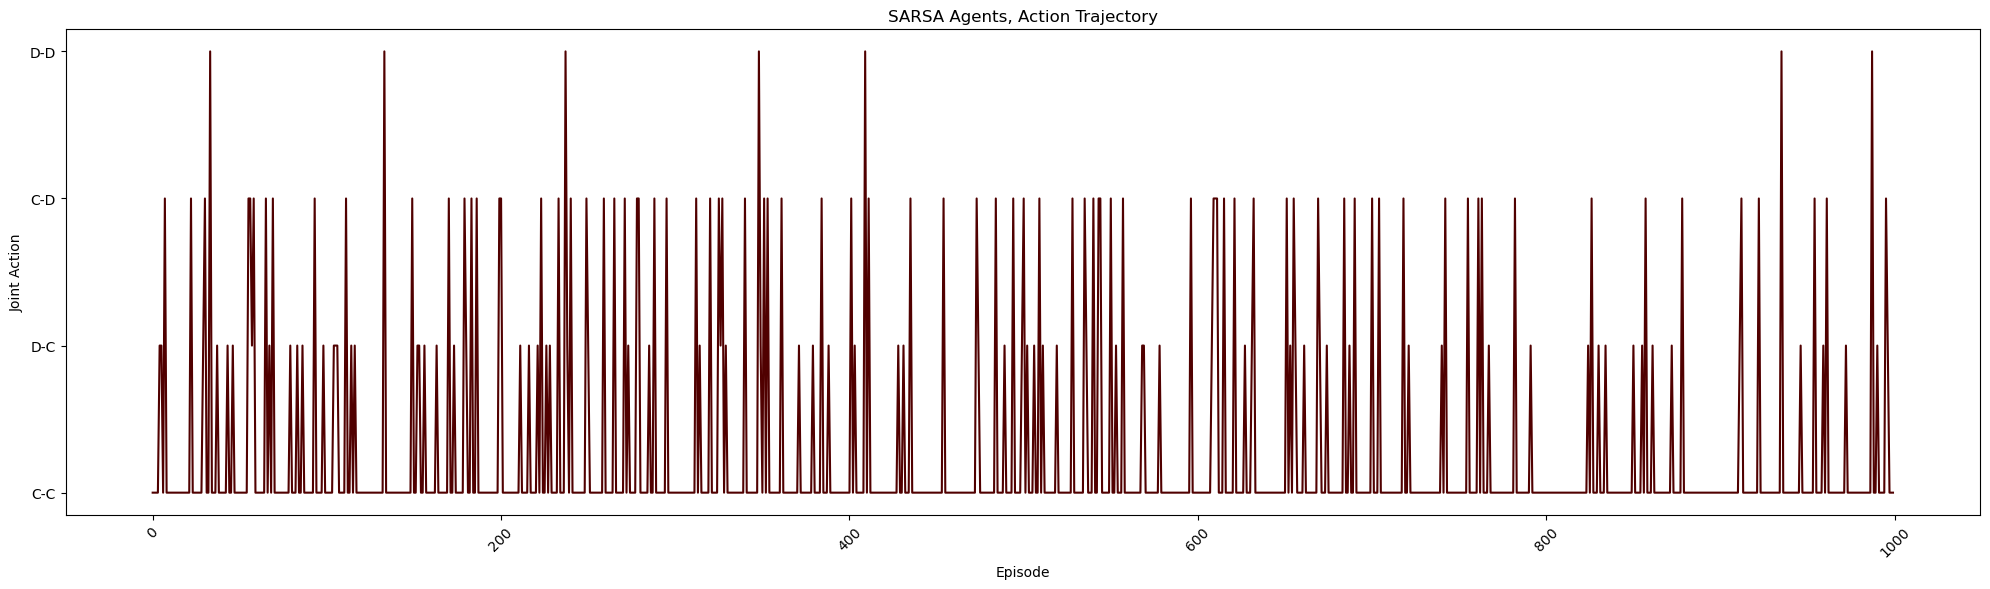


Learned Q-tables:


In [6]:
# plot results
plot_results(rewards1, title="Random Agents, Iterated Prisoner's Dilemma")
plot_cooperation(coop_rates1, title="Random Agents, Cooperation Rate")
plot_joint_action_distribution(joint_action_counts1, title="Random Agents, Joint Action Distribution")
plot_entropy(entropies1, title="Random Agents, Policy Entropy")
plot_trajectory(action_trajectories1, title="Random Agents, Action Trajectory")

plot_results(rewards2, title="Q-learning Agents, Iterated Prisoner's Dilemma")
plot_cooperation(coop_rates2, title="Q-learning Agents, Cooperation Rate")
plot_joint_action_distribution(joint_action_counts2, title="Q-learning Agents, Joint Action Distribution")
plot_entropy(entropies2, title="Q-learning Agents, Policy Entropy")
plot_trajectory(action_trajectories2, title="Q-learning Agents, Action Trajectory")

plot_results(rewards3, title="SARSA Agents, Iterated Prisoner's Dilemma")
plot_cooperation(coop_rates3, title="SARSA Agents, Cooperation Rate")
plot_joint_action_distribution(joint_action_counts3, title="SARSA Agents, Joint Action Distribution")
plot_entropy(entropies3, title="SARSA Agents, Policy Entropy")
plot_trajectory(action_trajectories3, title="SARSA Agents, Action Trajectory")

# print Q-tables when available 
print("\nLearned Q-tables:")
for idx, agent in enumerate(trained_agents1):
    if isinstance(agent, QLearningAgent):
        print(f"Agent {idx} Q-table:")
        for state, values in agent.Q.items():
            print(f"  State {state}: {values}")
